<a href="https://colab.research.google.com/github/RancyChepchirchir/hello-world/blob/master/vasicek_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
!pip install quandl
import quandl

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = quandl.get("FRED/DTB3", authtoken="mesng-xjfN_RUCyi_GJm")

In [3]:
df.head()

,Value
Date,
1954-01-04,1.33
1954-01-05,1.28
1954-01-06,1.28
1954-01-07,1.31
1954-01-08,1.31


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Value,16577.0,4.306803,3.095097,-0.05,2.04,4.17,5.85,17.14


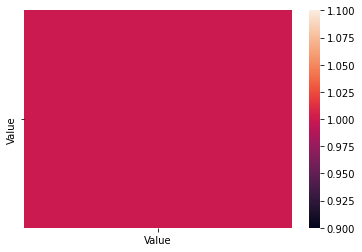

In [5]:
cor = df.corr()
sns.heatmap(cor)
plt.show()

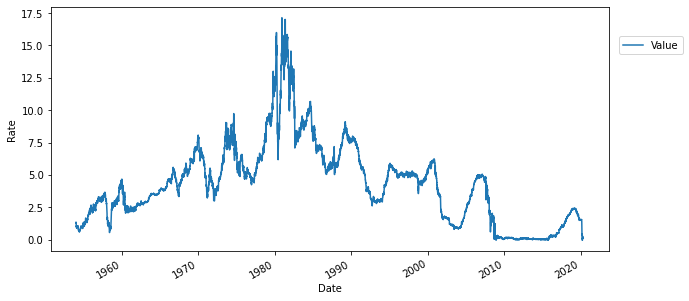

In [6]:
df.plot(figsize=(10,5))
plt.ylabel("Rate")
plt.legend(bbox_to_anchor=(1.01, 0.9), loc=2)
plt.show()

Of significance in interest rates is the strong mean reversion attribute. We can use a pretty basic stochastic model, the Vasicek short-rate model, to simulate out the rates. The typical implementation uses MLE to derive out the key parameters of the following model;

                dr(t)=κ(θ−rt)dt + σdW(t)

In [0]:
def VasicekNextRate(r, kappa, theta, sigma, dt=1/252):
    # Implements above closed form solution     
    val1 = np.exp(-1*kappa*dt)
    val2 = (sigma**2)*(1-val1**2) / (2*kappa)
    out = r*val1 + theta*(1-val1) + (np.sqrt(val2))*np.random.normal()
    return out

In [0]:
def VasicekSim(N, r0, kappa, theta, sigma, dt = 1/252):
    short_r = [0]*N # Create array to store rates   short_r[0] = r0 # Initialise rates at $r_0$     
    
    for i in range(1,N):
        short_r[i] = VasicekNextRate(short_r[i-1], kappa, theta, sigma, dt)
    
    return short_r

In [0]:
def VasicekMultiSim(M, N, r0, kappa, theta, sigma, dt = 1/252):
    sim_arr = np.ndarray((N, M))
    
    for i in range(0,M):
        sim_arr[:, i] = VasicekSim(N, r0, kappa, theta, sigma, dt)
    
    return sim_arr

In [0]:
def VasicekCalibration(df, dt=1/252):
    n = len(df)
    
    # Implement MLE to calibrate parameters  
    Sx = sum(df[0:(n-1)])
    Sy = sum(df[1:n])
    Sxx = np.dot(df[0:(n-1)], df[0:(n-1)])
    Sxy = np.dot(df[0:(n-1)], df[1:n])
    Syy = np.dot(df[1:n], df[1:n])
    
    theta = (Sy * Sxx - Sx * Sxy) / (n * (Sxx - Sxy) - (Sx**2 - Sx*Sy))
    kappa = -np.log((Sxy - theta * Sx - theta * Sy + n * theta**2) / (Sxx - 2*theta*Sx + n*theta**2)) / dt
    a = np.exp(-kappa * dt)
    sigmah2 = (Syy - 2*a*Sxy + a**2 * Sxx - 2*theta*(1-a)*(Sy - a*Sx) + n*theta**2 * (1-a)**2) / n
    sigma = np.sqrt(sigmah2*2*kappa / (1-a**2))
    r0 = df[n-1]
    
    return [kappa, theta, sigma, r0]

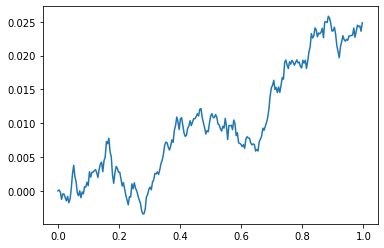

In [11]:
params = VasicekCalibration(df.Value.dropna()/100)
kappa = params[0]
theta = params[1]
sigma = params[2]
r0 = params[3]

years = 1
N = years * 252
t = np.arange(0,N)/252

test_sim = VasicekSim(N, r0, kappa, theta, sigma, 1/252)
plt.plot(t,test_sim)
plt.show()

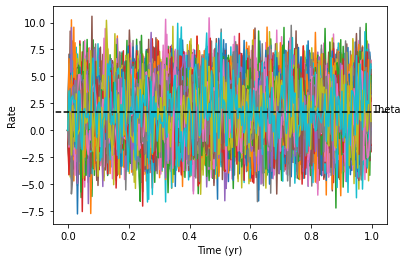

In [47]:
M = 100
rates_arr = VasicekMultiSim(M, N, r0, kappa, theta, sigma)

plt.plot(t,rates_arr)
plt.hlines(y=theta, xmin = -100, xmax=100, zorder=10, linestyles = 'dashed', label='Theta')
plt.annotate('Theta', xy=(1.0, theta+0.0005))
plt.xlim(-0.05, 1.05)
plt.ylabel("Rate")
plt.xlabel("Time (yr)")
plt.show()

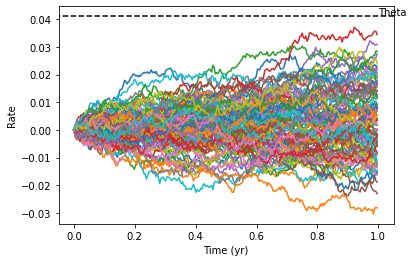

In [13]:
M = 100
rates_arr = VasicekMultiSim(M, N, -0.01, kappa, theta, sigma)
plt.plot(t,rates_arr)
plt.hlines(y=theta, xmin = -100, xmax=100, zorder=10, linestyles = 'dashed', label='Theta')
plt.annotate('Theta', xy=(1.0, theta+0.0005))
plt.xlim(-0.05, 1.05)
plt.ylabel("Rate")
plt.xlabel("Time (yr)")
plt.show()

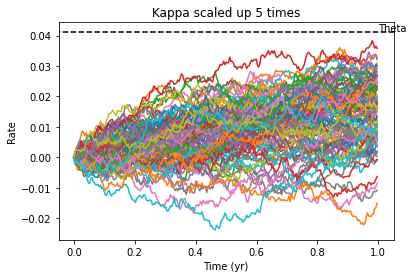

In [14]:
M = 100
rates_arr = VasicekMultiSim(M, N, -0.01, kappa*5, theta, sigma)
plt.plot(t,rates_arr)
plt.hlines(y=theta, xmin = -100, xmax=100, zorder=10, linestyles = 'dashed', label='Theta')
plt.annotate('Theta', xy=(1.0, theta+0.0005))
plt.xlim(-0.05, 1.05)
plt.ylabel("Rate")
plt.xlabel("Time (yr)")
plt.title("Kappa scaled up 5 times")
plt.show()

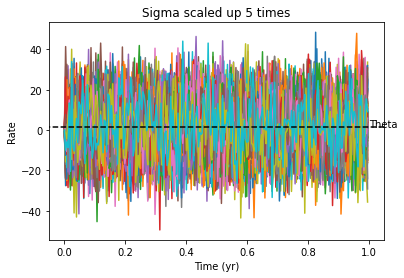

In [46]:
M = 100
rates_arr = VasicekMultiSim(M, N, -0.01, kappa, theta, sigma*5)
plt.plot(t,rates_arr)
plt.hlines(y=theta, xmin = -100, xmax=100, zorder=10, linestyles = 'dashed', label='Theta')
plt.annotate('Theta', xy=(1.0, theta+0.0005))
plt.xlim(-0.05, 1.05)
plt.ylabel("Rate")
plt.xlabel("Time (yr)")
plt.title("Sigma scaled up 5 times")
plt.show()

In [16]:
params[0], params[1], params[2], params[3]     #mle estimates

(0.09276337619668949, 0.041084684712247806, 0.013816643633384912, 0.0012)

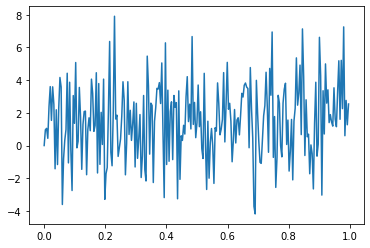

In [22]:
data = np.random.lognormal(size=16577)     #simulated series using the mle parameters
params = VasicekCalibration(data)
kappa = params[0]
theta = params[1]
sigma = params[2]
r0 = params[3]

years = 1
N = years * 252
t = np.arange(0,N)/252

test_sim = VasicekSim(N, r0, kappa, theta, sigma, 1/252)
plt.plot(t,test_sim)
plt.show()